# Lab 8


## Setup for SUSY Dataset

Use the SUSY dataset for the rest of this lab. Here is a basic setup.

In [1]:
# Our usual libraries...
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML, display
import tabulate
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, auc, confusion_matrix

In [2]:
filename = "SUSY-small.csv"
VarNames=["signal", "l_1_pT", "l_1_eta","l_1_phi", "l_2_pT", "l_2_eta", 
          "l_2_phi", "MET", "MET_phi", "MET_rel", "axial_MET",
          "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
df = pd.read_csv(filename, dtype='float64', names=VarNames)

## Scikit-Learn

[Scikit-learn](http://scikit-learn.org) is a rich python library for data science, including machine learning. For example, we can build a Fisher Discriminant (aka Linear Discriminant Analysis, or LDA). 

### Exercise 1: Install Scikit-Learn

Follow the [Installation Instructions](https://scikit-learn.org/stable/install.html) and install `scikit-learn` in your environment.

In [3]:
!pip3 install scikit-learn

In [4]:
import sklearn
print(sklearn.__version__)

1.3.0


### Exercise 2: Read About Classifiers

#### Part a
Scikit-learn offers an impressively comprehensive list of machine learning algorithms. Browse through [scikit-learn's documentation](https://scikit-learn.org/stable/index.html). You'll note the algorithms are organized into classification, regression, clustering, dimensionality reduction, model selection, and preprocessing. Browse through the list of [classification algorithms](https://scikit-learn.org/stable/supervised_learning.html#supervised-learning). 

#### Part b
Note scikit-learn's documentation is rather comprehensive. The documentation on [linear models](https://scikit-learn.org/stable/modules/linear_model.html) shows how classification problems are setup. Read about the first few methods and try to comprehend the example codes. Skim the rest of the document.

#### Part c
Read through the [LDA Documentation](https://scikit-learn.org/stable/modules/lda_qda.html).


### Exercise 3: Training a Classifier

Lets' repeat what we did manually in the previous lab using scikit-learn. We'll use a LDA classifier, which we can instanciate as follows:

In [5]:
import sklearn.discriminant_analysis as DA
Fisher=DA.LinearDiscriminantAnalysis()

As discussed in the lecture, to properly formulate our problem, we'll have to:

* Define the inputs (X) vs outputs (Y)
* Designate training vs testing samples (in order to get a unbias assessment of the performance of Machine Learning algorithms)

for example, here we'll take use 4M events for training and the remainder for testing.

In [6]:
N_Train=40000000

Train_Sample=df[:N_Train]
Test_Sample=df[N_Train:]

X_Train=Train_Sample[VarNames[1:]]
y_Train=Train_Sample["signal"]

X_Test=Test_Sample[VarNames[1:]]
y_Test=Test_Sample["signal"]

Test_sig=Test_Sample[Test_Sample.signal==1]
Test_bkg=Test_Sample[Test_Sample.signal==0]


We can train the classifier as follow:

In [7]:
Fisher.fit(X_Train,y_Train)

LinearDiscriminantAnalysis()

In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

# Set up the split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(df, df['signal']):
    Train_Sample = df.iloc[train_index]
    Test_Sample = df.iloc[test_index]

# Separate features and target variables
X_Train = Train_Sample[VarNames[1:]]
y_Train = Train_Sample["signal"]
X_Test = Test_Sample[VarNames[1:]]
y_Test = Test_Sample["signal"]

# Check the shape to confirm
print("Train_Sample size:", Train_Sample.shape)
print("Test_Sample size:", Test_Sample.shape)



Train_Sample size: (400000, 19)
Test_Sample size: (100000, 19)


In [9]:
Test_sig = Test_Sample[Test_Sample['signal'] == 1]
Test_bkg = Test_Sample[Test_Sample['signal'] == 0]

We can plot the output, comparing signal and background:

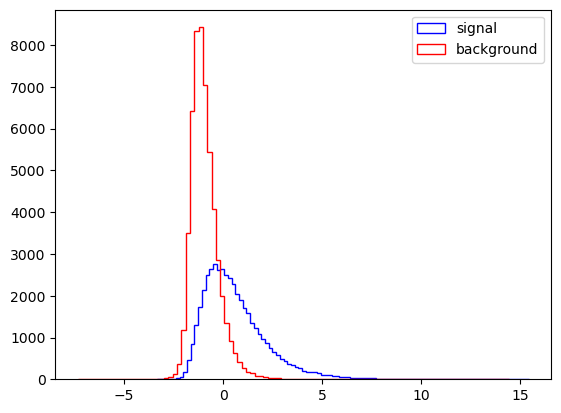

In [10]:
plt.figure()
plt.hist(Fisher.decision_function(Test_sig[VarNames[1:]]), bins=100, histtype="step", color="blue", label="signal", stacked=True)
plt.hist(Fisher.decision_function(Test_bkg[VarNames[1:]]), bins=100, histtype="step", color="red", label="background", stacked=True)
plt.legend(loc='upper right')
plt.show()

#### Part a

Compare ROC curves computed on the test versus training samples, in a single plot. Do you see a bias?

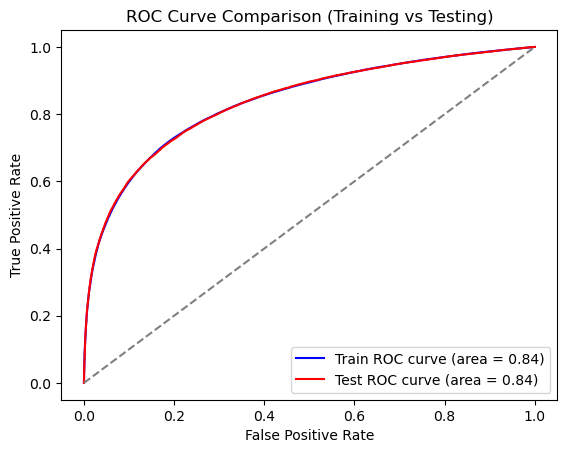

In [11]:
from sklearn.metrics import roc_curve, auc

y_train_score = Fisher.decision_function(X_Train)
y_test_score = Fisher.decision_function(X_Test)

# Compute ROC curve and AUC for the training data
fpr_train, tpr_train, _ = roc_curve(y_Train, y_train_score)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for the testing data
fpr_test, tpr_test, _ = roc_curve(y_Test, y_test_score)
roc_auc_test = auc(fpr_test, tpr_test)

plt.figure()
plt.plot(fpr_train, tpr_train, color="blue", label=f"Train ROC curve (area = {roc_auc_train:.2f})")
plt.plot(fpr_test, tpr_test, color="red", label=f"Test ROC curve (area = {roc_auc_test:.2f})")
plt.plot([0, 1], [0, 1], color="grey", linestyle="--")  # Diagonal line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison (Training vs Testing)")
plt.legend(loc="lower right")
plt.show()


#### Part b

Train the Fisher performance of using the raw, features, and raw+features as input. Compare the performance one a single plot. 

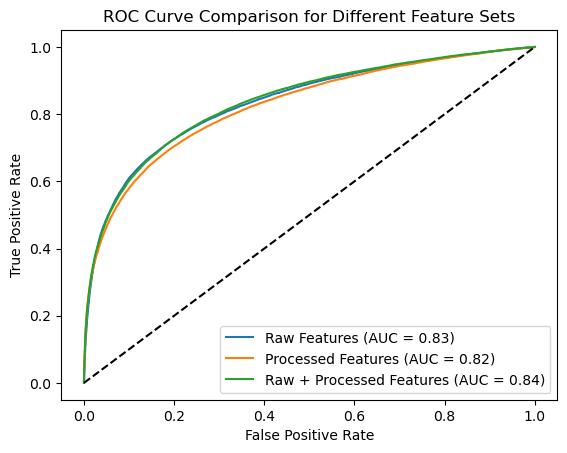

In [12]:
raw_features = ["l_1_pT", "l_1_eta", "l_1_phi", "l_2_pT", "l_2_eta", "l_2_phi", "MET", "MET_phi"]
processed_features = ["MET_rel", "axial_MET", "M_R", "M_TR_2", "R", "MT2", "S_R", "M_Delta_R", "dPhi_r_b", "cos_theta_r1"]
combined_features = raw_features + processed_features

X_raw, X_raw_test = Train_Sample[raw_features], Test_Sample[raw_features]
X_processed, X_processed_test = Train_Sample[processed_features], Test_Sample[processed_features]
X_combined, X_combined_test = Train_Sample[combined_features], Test_Sample[combined_features]

roc_data = {}

def calculate_roc(X_train, X_test, y_train, y_test, label):
    model = DA.LinearDiscriminantAnalysis()
    model.fit(X_train, y_train)
    fpr, tpr, _ = roc_curve(y_test, model.decision_function(X_test))
    roc_data[label] = (fpr, tpr, auc(fpr, tpr))

# Calculate and store ROC for each feature set
calculate_roc(X_raw, X_raw_test, y_Train, y_Test, "Raw Features")
calculate_roc(X_processed, X_processed_test, y_Train, y_Test, "Processed Features")
calculate_roc(X_combined, X_combined_test, y_Train, y_Test, "Raw + Processed Features")

plt.figure()
for label, (fpr, tpr, roc_auc) in roc_data.items():
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Different Feature Sets")
plt.legend(loc="lower right")
plt.show()


### Exercise 4: Comparing Techniques

#### Part a
Select 3 different classifiers from the techniques listed [here](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) to compare. Note that you can use the multi-layer perceptron to build a deep network, though training may be prohibitively slow. So avoid this technique.

#### Part b

Write a function that takes an instantiated classifier and performs the comparison from part 3b. Use the function on your choice of functions in part a.

#### Part c

Use the best method from part c to compute the maximal significance $\sigma_S= \frac{N_S}{\sqrt{N_S+N_B}}$ for the scenarios in lab 5.

Evaluating Support Vector Machine...
Evaluating Random Forest...
Evaluating Naive Bayes...


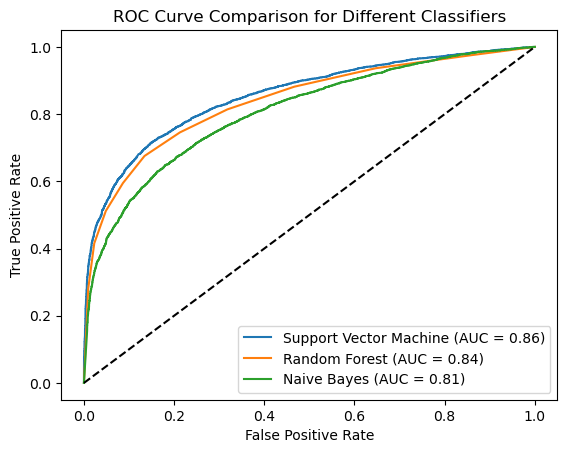

Maximal Significance (σ_S) for Support Vector Machine: 50.28


In [13]:
# Configure selected Classifiers
classifiers = {
    "Support Vector Machine": SVC(kernel='linear', probability=True),  # Linear kernel for faster SVM
    "Random Forest": RandomForestClassifier(n_estimators=10, n_jobs=-1),  # Reduced estimators for faster processing
    "Naive Bayes": GaussianNB()
}

# Reduce Data Size for Testing
# Use a smaller subset of data for initial testing to speed up execution
from sklearn.model_selection import train_test_split

X_Train_small, _, y_Train_small, _ = train_test_split(X_Train, y_Train, test_size=0.9, random_state=42)
X_Test_small, _, y_Test_small, _ = train_test_split(X_Test, y_Test, test_size=0.9, random_state=42)

roc_data = {}

# Define Evaluation Function
def evaluate_classifier(clf, X_train, X_test, y_train, y_test, label):
    clf.fit(X_train, y_train)
    y_score = clf.predict_proba(X_test)[:, 1] if hasattr(clf, "predict_proba") else clf.decision_function(X_test)
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    roc_data[label] = (fpr, tpr, roc_auc)

    y_pred = clf.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    return tp, fp 

plt.figure()
best_auc = 0
best_clf_data = None
for label, clf in classifiers.items():
    print(f"Evaluating {label}...")
    Ns, Nb = evaluate_classifier(clf, X_Train_small, X_Test_small, y_Train_small, y_Test_small, label)
    fpr, tpr, roc_auc = roc_data[label]
    plt.plot(fpr, tpr, label=f"{label} (AUC = {roc_auc:.2f})")
    
    if roc_auc > best_auc:
        best_auc = roc_auc
        best_clf_data = (label, Ns, Nb)

plt.plot([0, 1], [0, 1], "k--")  
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison for Different Classifiers")
plt.legend(loc="lower right")
plt.show()

# Part c - Calculate Maximal Significance for Best Classifier
if best_clf_data:
    best_label, Ns, Nb = best_clf_data
    sigma_S = Ns / (Ns + Nb)**0.5
    print(f"Maximal Significance (σ_S) for {best_label}: {sigma_S:.2f}")


### Exercise 5: Metrics

Scikit-learn provides methods for computing the FPR, TPR, ROC, AUC metrics. For example:

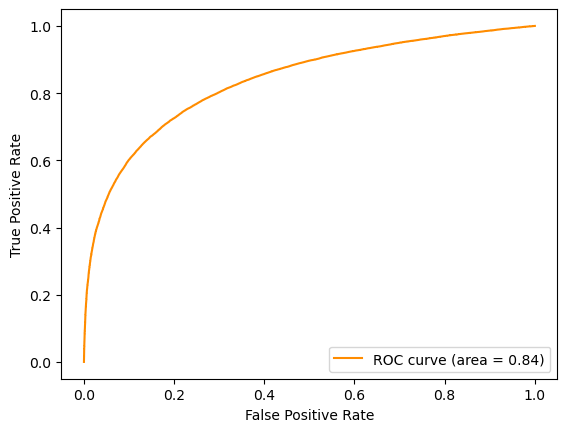

In [14]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_Test, Fisher.decision_function(X_Test))

roc_auc = auc(fpr, tpr)

plt.plot(fpr,tpr,color='darkorange',label='ROC curve (area = %0.2f)' % roc_auc)
plt.legend(loc="lower right")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()


#### Part a
TPR/FPR/ROC/AUC are one way of assessing the quality of a classifier. Read about [Precision and Recall](https://en.wikipedia.org/wiki/Precision_and_recall), [Accuracy](https://en.wikipedia.org/wiki/Accuracy_and_precision), and [F-score](https://en.wikipedia.org/wiki/F-score).

#### Part b
Look through [model evaluation](https://scikit-learn.org/stable/modules/model_evaluation.html#) documentation. Using scikit-learns tools, compute TPR, FPR, ROC, AUC, Precision, Recall, F1 score, and accuracy for the method you selected in 4c above and each scenario. Make a nice table, which also includes the maximal significance. 


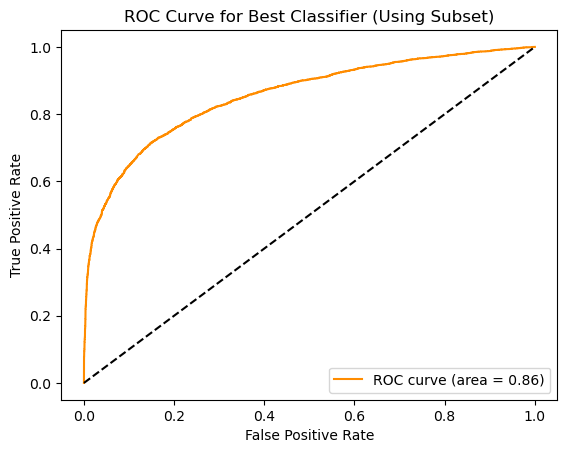

Metrics for Best Classifier (Using Subset):
                 Metric      Value
0                   AUC   0.855151
1             Precision   0.836656
2                Recall   0.660114
3              F1 Score   0.737973
4              Accuracy   0.785400
5  Maximal Significance  50.282932


In [15]:
from sklearn.metrics import roc_curve, auc, precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split

# Define the best classifier from Exercise 4 
best_clf = SVC(kernel='linear', probability=True)

# Use a smaller subset for testing
X_small_train, _, y_small_train, _ = train_test_split(X_Train, y_Train, test_size=0.9, random_state=42)
X_small_test, _, y_small_test, _ = train_test_split(X_Test, y_Test, test_size=0.9, random_state=42)

# Fit the best classifier on the smaller subset
best_clf.fit(X_small_train, y_small_train)

# Predictions and probability scores for the smaller test set
y_pred = best_clf.predict(X_small_test)
y_score = best_clf.predict_proba(X_small_test)[:, 1] if hasattr(best_clf, "predict_proba") else best_clf.decision_function(X_small_test)

# Compute evaluation metrics
fpr, tpr, _ = roc_curve(y_small_test, y_score)
roc_auc = auc(fpr, tpr)
precision = precision_score(y_small_test, y_pred)
recall = recall_score(y_small_test, y_pred)
f1 = f1_score(y_small_test, y_pred)
accuracy = accuracy_score(y_small_test, y_pred)

# Confusion matrix values for maximal significance calculation
tn, fp, fn, tp = confusion_matrix(y_small_test, y_pred).ravel()
Ns = tp  
Nb = fp  
sigma_S = Ns / (Ns + Nb)**0.5  

plt.figure()
plt.plot(fpr, tpr, color="darkorange", label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Best Classifier (Using Subset)")
plt.legend(loc="lower right")
plt.show()

# Display Metrics 
metrics_table = pd.DataFrame({
    "Metric": ["AUC", "Precision", "Recall", "F1 Score", "Accuracy", "Maximal Significance"],
    "Value": [roc_auc, precision, recall, f1, accuracy, sigma_S]
})

print("Metrics for Best Classifier (Using Subset):")
print(metrics_table)
